**Linear Regression**

Fold 1
  Train R²: 0.6040
  Train MSE: 126.88
  Test  R²: 0.6026
  Test  MSE: 126.77

Fold 2
  Train R²: 0.6056
  Train MSE: 126.66
  Test  R²: 0.5961
  Test  MSE: 127.63

Fold 3
  Train R²: 0.6036
  Train MSE: 126.42
  Test  R²: 0.6044
  Test  MSE: 128.63

Fold 4
  Train R²: 0.6028
  Train MSE: 126.81
  Test  R²: 0.6076
  Test  MSE: 127.09

Fold 5
  Train R²: 0.6040
  Train MSE: 127.12
  Test  R²: 0.6028
  Test  MSE: 125.80

Cross-Validation Summary:
Average Train R²: 0.6040
Average Train MSE: 126.78
Average Test  R²: 0.6027
Average Test  MSE: 127.18
Best Fold Test R²: 0.6076

Top 15 Important Features from Best Model:
                        Feature  Coefficient
72          track_genre_iranian   -35.774444
106         track_genre_romance   -34.884326
37   track_genre_detroit-techno   -32.340691
26    track_genre_chicago-house   -31.609218
33            track_genre_dance    31.452020
103            track_genre_rock    30.290802
79             track_genre_kids   -29.466261
55        tr

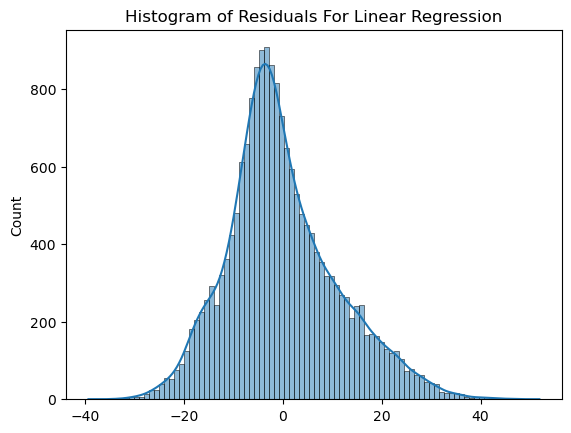

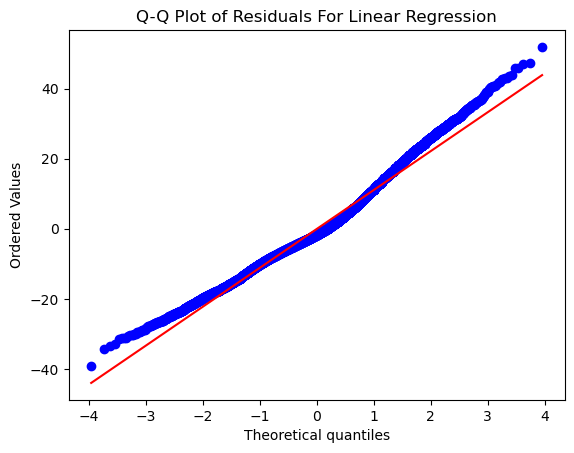

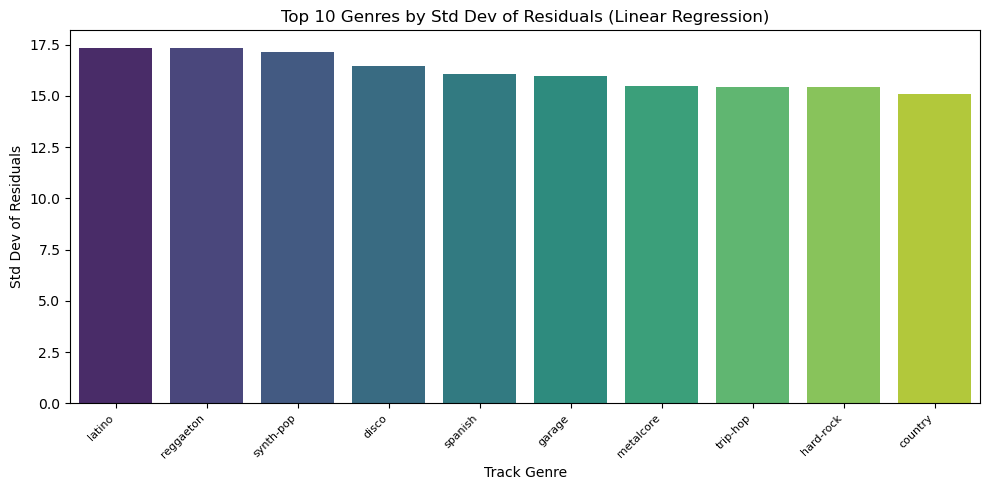

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

df = pd.read_csv('Cleaned_Dataset.csv')

df = df.drop(columns=['Unnamed: 0', 'release_date', 'track_id', 'artists', 'album_name', 'track_name'])

# One-hot encode the 'track_genre' column
df = pd.get_dummies(df, columns=['track_genre'], drop_first=True)

# Define features and target
X = df.drop(columns=['popularity'])
y = df['popularity']

# Set number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_array = X.values
y_array = y.values
feature_names = X.columns

# Initialize lists to store metrics
train_r2_scores = []
train_mse_scores = []
test_r2_scores = []
test_mse_scores = []

best_model = None
best_test_r2 = -np.inf
best_coef = None

fold = 1
for train_index, test_index in kf.split(X_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    print(f"Fold {fold}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Train MSE: {train_mse:.2f}")
    print(f"  Test  R²: {test_r2:.4f}")
    print(f"  Test  MSE: {test_mse:.2f}")
    print()

    train_r2_scores.append(train_r2)
    train_mse_scores.append(train_mse)
    test_r2_scores.append(test_r2)
    test_mse_scores.append(test_mse)

    if test_r2 > best_test_r2:
        best_test_r2 = test_r2
        best_model = model
        best_coef = model.coef_

    fold += 1

# Summary stats
print("Cross-Validation Summary:")
print(f"Average Train R²: {np.mean(train_r2_scores):.4f}")
print(f"Average Train MSE: {np.mean(train_mse_scores):.2f}")
print(f"Average Test  R²: {np.mean(test_r2_scores):.4f}")
print(f"Average Test  MSE: {np.mean(test_mse_scores):.2f}")
print(f"Best Fold Test R²: {best_test_r2:.4f}")

# Feature importances from best model
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_coef,
    'Abs_Coefficient': np.abs(best_coef)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("\nTop 15 Important Features from Best Model:")
print(coef_df[['Feature', 'Coefficient']].head(15))

residuals = y_test - y_test_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Linearity Check) For Linear Regression")
plt.show()

# Histogram
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals For Linear Regression")
plt.show()

# Q-Q Plot
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For Linear Regression")
plt.show()

# --- Residual Ranking by Genre Standard Deviation ---

# Reload original DataFrame to retain genre info
df_full = pd.read_csv('Cleaned_Dataset.csv')

# Reset index before splitting so we can trace back
df_full = df_full.drop(columns=['Unnamed: 0', 'release_date', 'track_id', 'artists', 'album_name', 'track_name'])
df_full = pd.get_dummies(df_full, columns=['track_genre'], drop_first=True)

# Get track_genre column before one-hot encoding
genre_col = pd.read_csv('Cleaned_Dataset.csv')['track_genre']

# Create DataFrame to hold residuals and genre labels
# Get the test indices from the last fold
test_genres = genre_col.iloc[test_index].reset_index(drop=True)
residuals_df = pd.DataFrame({
    'residuals': residuals,
    'track_genre': test_genres
})

# Group by genre and calculate std dev of residuals
genre_std = residuals_df.groupby('track_genre')['residuals'].std().sort_values(ascending=False)

# Select only top 10 genres
top10_genre_std = genre_std.head(10)

# Bar plot of top 10 residual spread
plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette='viridis')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (Linear Regression)")
plt.ylabel("Std Dev of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**Regular Decision Tree**

Train R^2: 0.5428801347726562
Train MSE: 146.46990800168842
Test R^2: 0.5378261009444337
Test MSE: 147.44459222166566


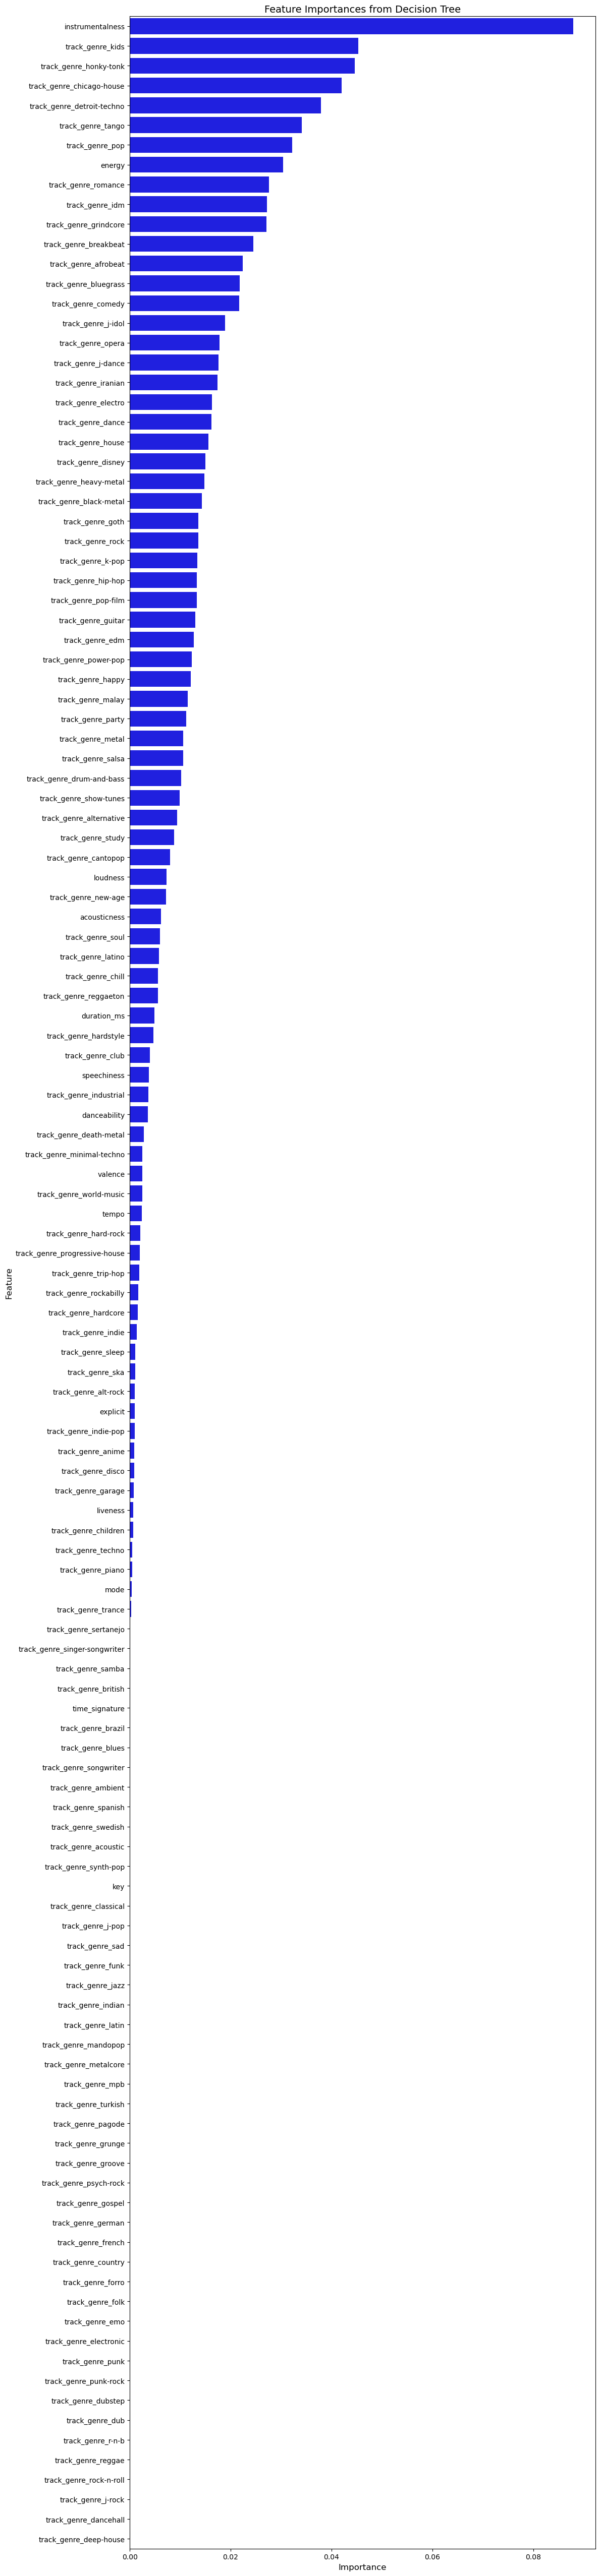

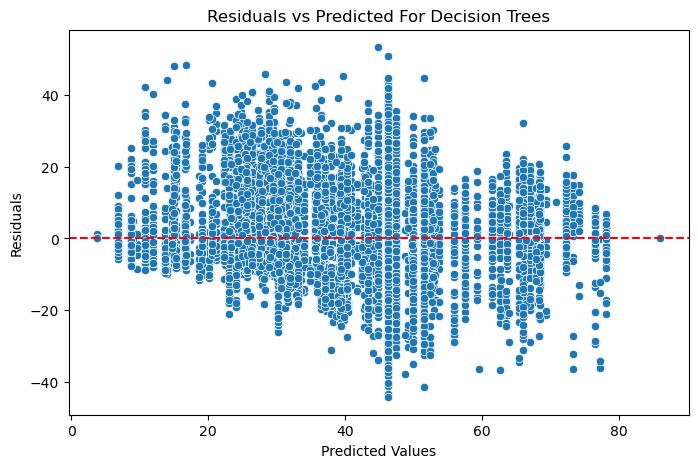

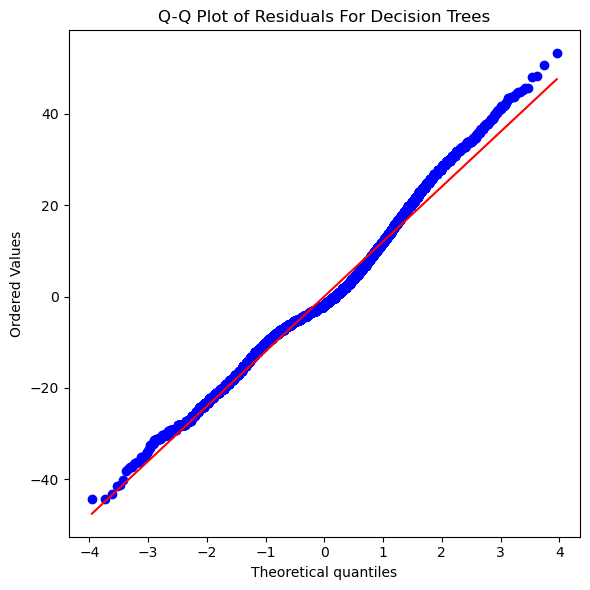

In [42]:
# Regular Decision Tree using Bayesian Optimization to Find All Of The Best Parameters

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import scipy.stats as stats
import numpy as np

# Load data
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

# Feature specification
numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Best model parameters (from Bayesian optimization)
model = DecisionTreeRegressor(
    random_state=42,
    ccp_alpha=0.05,
    max_depth=40,
    min_samples_leaf=1,
    min_samples_split=50
)

# Pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

# Fit pipeline
pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluation metrics
print("Train R^2:", r2_score(y_train, y_train_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

# Plot decision tree
best_tree = pipeline.named_steps['model']
X_encoded = preprocessor.fit_transform(X_train)
ohe = preprocessor.named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

# --- Feature Importances from Decision Tree (Cleaned Plot) ---
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances
importances = best_tree.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]

# Plot
plt.figure(figsize=(12, len(sorted_features) * 0.4))  # Dynamically adjust height
sns.barplot(x=importances[indices], y=sorted_features, color="blue")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Importances from Decision Tree", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Residuals analysis
residuals = y_test - y_test_pred

# Residuals vs. predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted For Decision Trees")
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals For Decision Trees")
plt.show()

# Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For Decision Trees")
plt.tight_layout()
plt.show()

# Residuals by Genre
X_test_original = X_test.copy()
X_test_original['residuals'] = residuals
X_test_original['track_genre'] = X.loc[X_test.index]['track_genre'].values

# Compute std deviation and sort
genre_std = X_test_original.groupby('track_genre')['residuals'].std().sort_values(ascending=False)

# Take top 10 genres only
top10_genre_std = genre_std.head(10)

# Bar plot: Top 10 residual std dev by genre
plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="magma")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (Decision Tree)")
plt.ylabel("Std Deviation of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**How We Found The Best Parameters For Random Forest**

In [3]:
# Random Forest using Bayesian Optimization to Find All Of The Best Parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

search_space = {
    'model__n_estimators': Integer(100, 300),
    'model__max_depth': Integer(10, 40),
    'model__min_samples_leaf': Integer(1, 10),
    'model__min_samples_split': Integer(2, 10),
    'model__max_features': Categorical(['sqrt', 'log2'])
}

# Bayesian Optimization
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    n_iter=30,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train, y_train)

best_pipeline = opt.best_estimator_
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

print("Best Parameters:", opt.best_params_)
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

rf_model = best_pipeline.named_steps['model']
ohe = best_pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances (Bayesian Optimized)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

**Random Forest**

Train R²: 0.7315324174028264
Test R²: 0.5888169678330661
Test MSE: 131.17727900733868


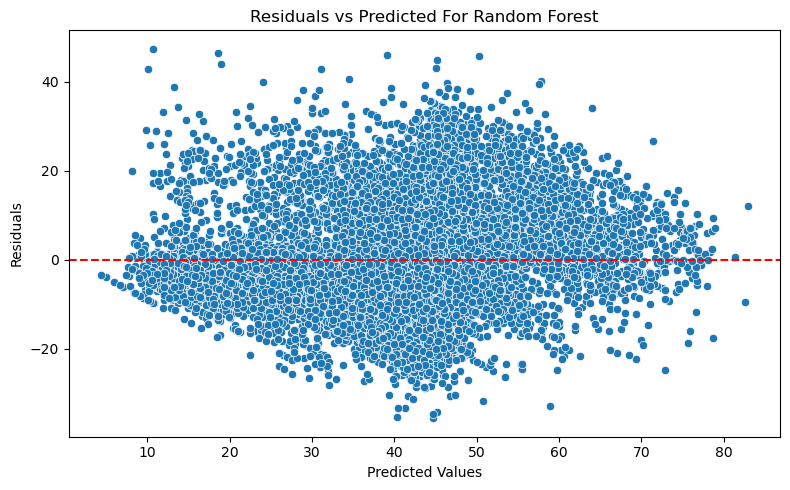

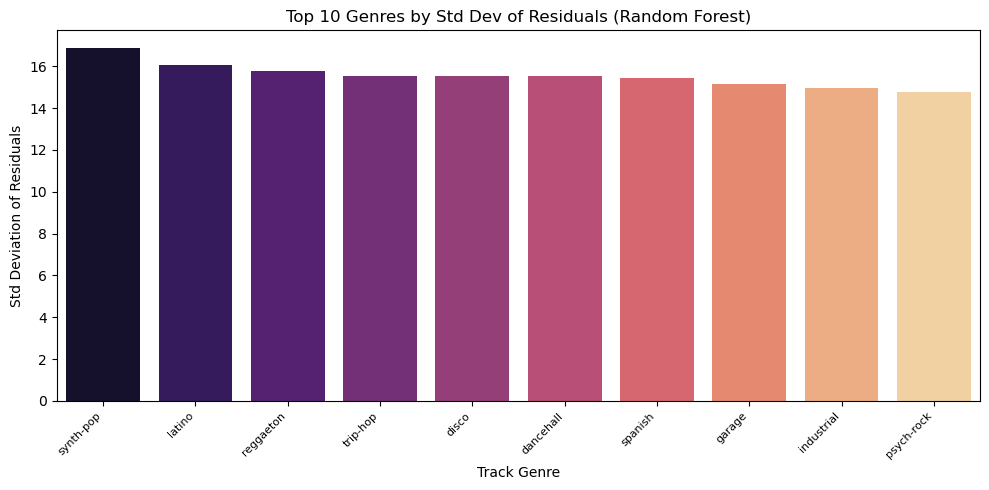

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Load and prepare data
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']

X = df[numerical_features + categorical_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Final model with best parameters
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=40,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

# Pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

# Train model
pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Metrics
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

# Feature importances
rf_model = pipeline.named_steps['model']
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, len(indices) * 0.3))  # Dynamically adjust height
plt.title("Random Forest Feature Importances (Final Optimized)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=8)  # Smaller font size
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# --- Residuals Analysis ---
residuals = y_test - y_test_pred

# Residuals vs Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted For Random Forest")
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals For Random Forest")
plt.tight_layout()
plt.show()

# Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For Random Forest")
plt.tight_layout()
plt.show()

# Residuals by Genre
X_test_original = X_test.copy()
X_test_original['residuals'] = residuals
X_test_original['track_genre'] = X.loc[X_test.index]['track_genre'].values

# Compute std deviation and sort
genre_std = X_test_original.groupby('track_genre')['residuals'].std().sort_values(ascending=False)

# Take top 10 genres only
top10_genre_std = genre_std.head(10)

# Bar plot: Top 10 residual std dev by genre
plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="magma")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (Random Forest)")
plt.ylabel("Std Deviation of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**XGBoost**

XGBoost Results:
Train R²: 0.9207801818847656
Test R²: 0.6897764205932617
Test MSE: 98.96878814697266


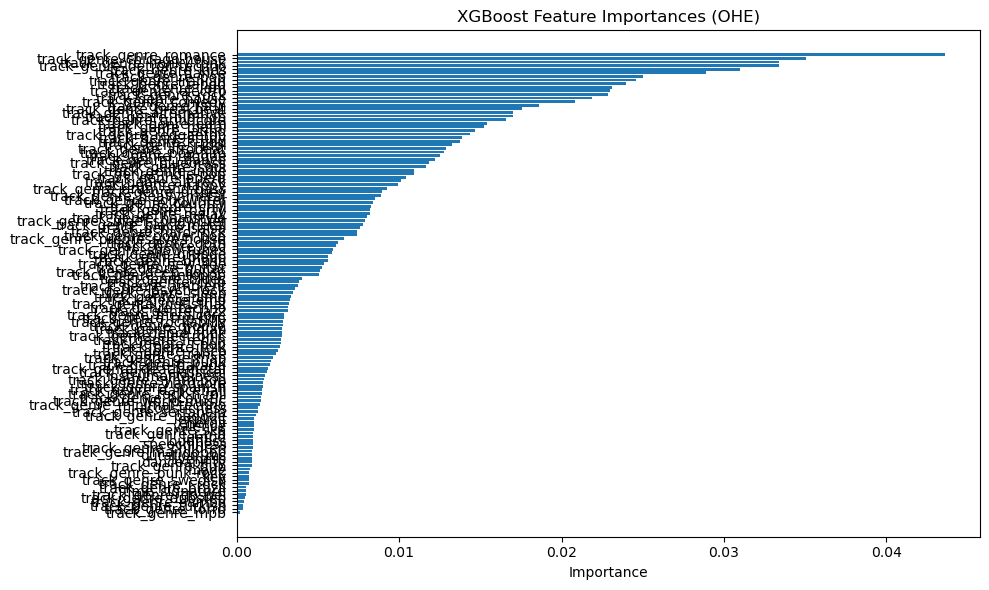

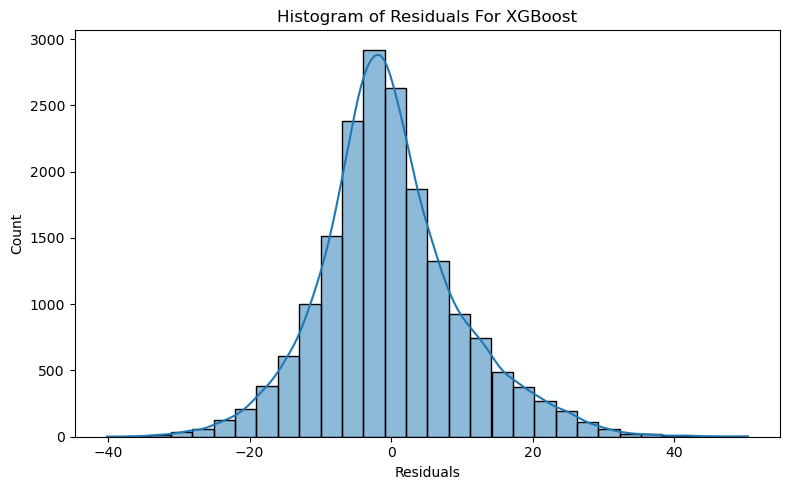

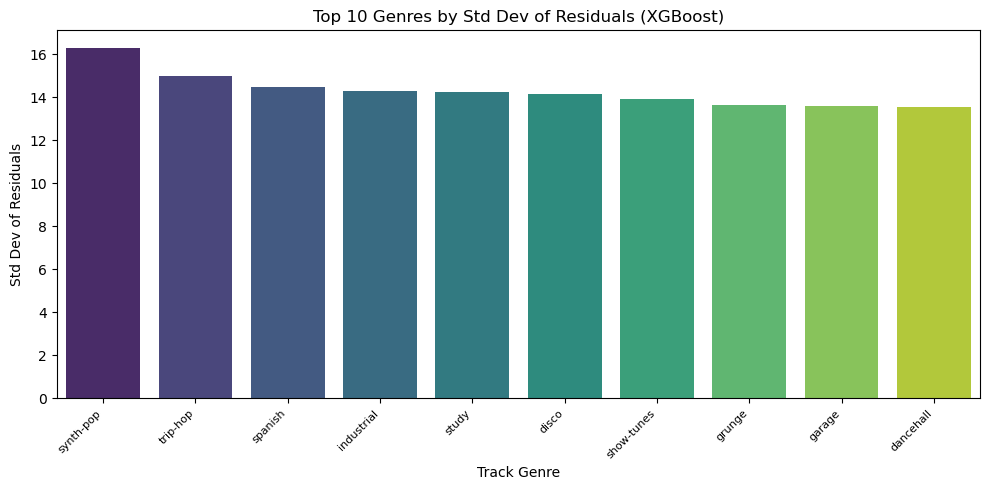

In [37]:
# XGBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Use best parameters from Bayesian search
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        colsample_bytree=0.5,
        learning_rate=0.07144343159553798,
        max_depth=15,
        n_estimators=500,
        reg_alpha=10.0,
        reg_lambda=10.0,
        subsample=0.5
    ))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

results = {
    "Train R²": r2_score(y_train, y_train_pred),
    "Test R²": r2_score(y_test, y_test_pred),
    "Test MSE": mean_squared_error(y_test, y_test_pred)
}

xgb_model = pipeline.named_steps['model']
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

print("XGBoost Results:")
for key, value in results.items():
    print(f"{key}: {value}")

plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importances (OHE)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - y_test_pred

# Residuals vs Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted For XGBoost")
plt.tight_layout()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals For XGBoost")
plt.tight_layout()
plt.show()

# Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For XGBoost")
plt.tight_layout()
plt.show()

# Residuals by Genre
X_test_original = X_test.copy()
X_test_original['residuals'] = residuals
X_test_original['track_genre'] = X.loc[X_test.index]['track_genre'].values

# Compute std deviation and sort
genre_std = X_test_original.groupby('track_genre')['residuals'].std().sort_values(ascending=False)

# Take top 10 genres only
top10_genre_std = genre_std.head(10)

# Bar plot: Top 10 residual std dev by genre
plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="viridis")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (XGBoost)")
plt.ylabel("Std Dev of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**Finding The Best Parameters For Bagged Forest**

C:\Users\xayas\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagged Forest Results:
Best Parameters: OrderedDict([('model__base_estimator__max_depth', 30), ('model__base_estimator__min_samples_leaf', 4), ('model__n_estimators', 76)])
Train R²: 0.5827983107198438
Test R²: 0.5208868856796988
Test MSE: 152.84860939435237


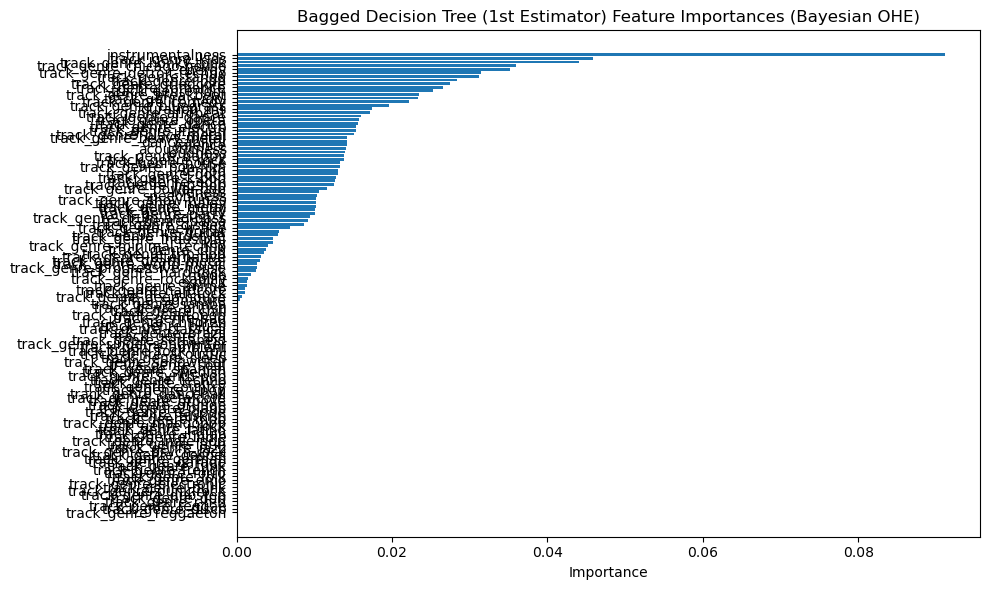

In [9]:
# Bagged Forest using Bayesian Optimization to Find All Of The Best Parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Integer

df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', BaggingRegressor(
        base_estimator=DecisionTreeRegressor(random_state=42),
        random_state=42,
        n_jobs=-1
    ))
])

search_spaces = {
    'model__n_estimators': Integer(10, 100),
    'model__base_estimator__max_depth': Integer(5, 30),
    'model__base_estimator__min_samples_leaf': Integer(1, 10)
}

# Bayesian Optimization
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces,
    n_iter=30,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

opt.fit(X_train, y_train)
best_pipeline = opt.best_estimator_
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

results = {
    "Best Parameters": opt.best_params_,
    "Train R²": r2_score(y_train, y_train_pred),
    "Test R²": r2_score(y_test, y_test_pred),
    "Test MSE": mean_squared_error(y_test, y_test_pred)
}

first_tree = best_pipeline.named_steps['model'].estimators_[0]
ohe = best_pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = first_tree.feature_importances_
indices = np.argsort(importances)

print("Bagged Forest Results:")
for key, value in results.items():
    print(f"{key}: {value}")

plt.figure(figsize=(10, 6))
plt.title("Bagged Decision Tree (1st Estimator) Feature Importances (Bayesian OHE)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Bagged Decision Tree**

Bagged Forest Results:
Train R²: 0.5828266470833375
Test R²: 0.5209038731467295
Test MSE: 152.84318998370554


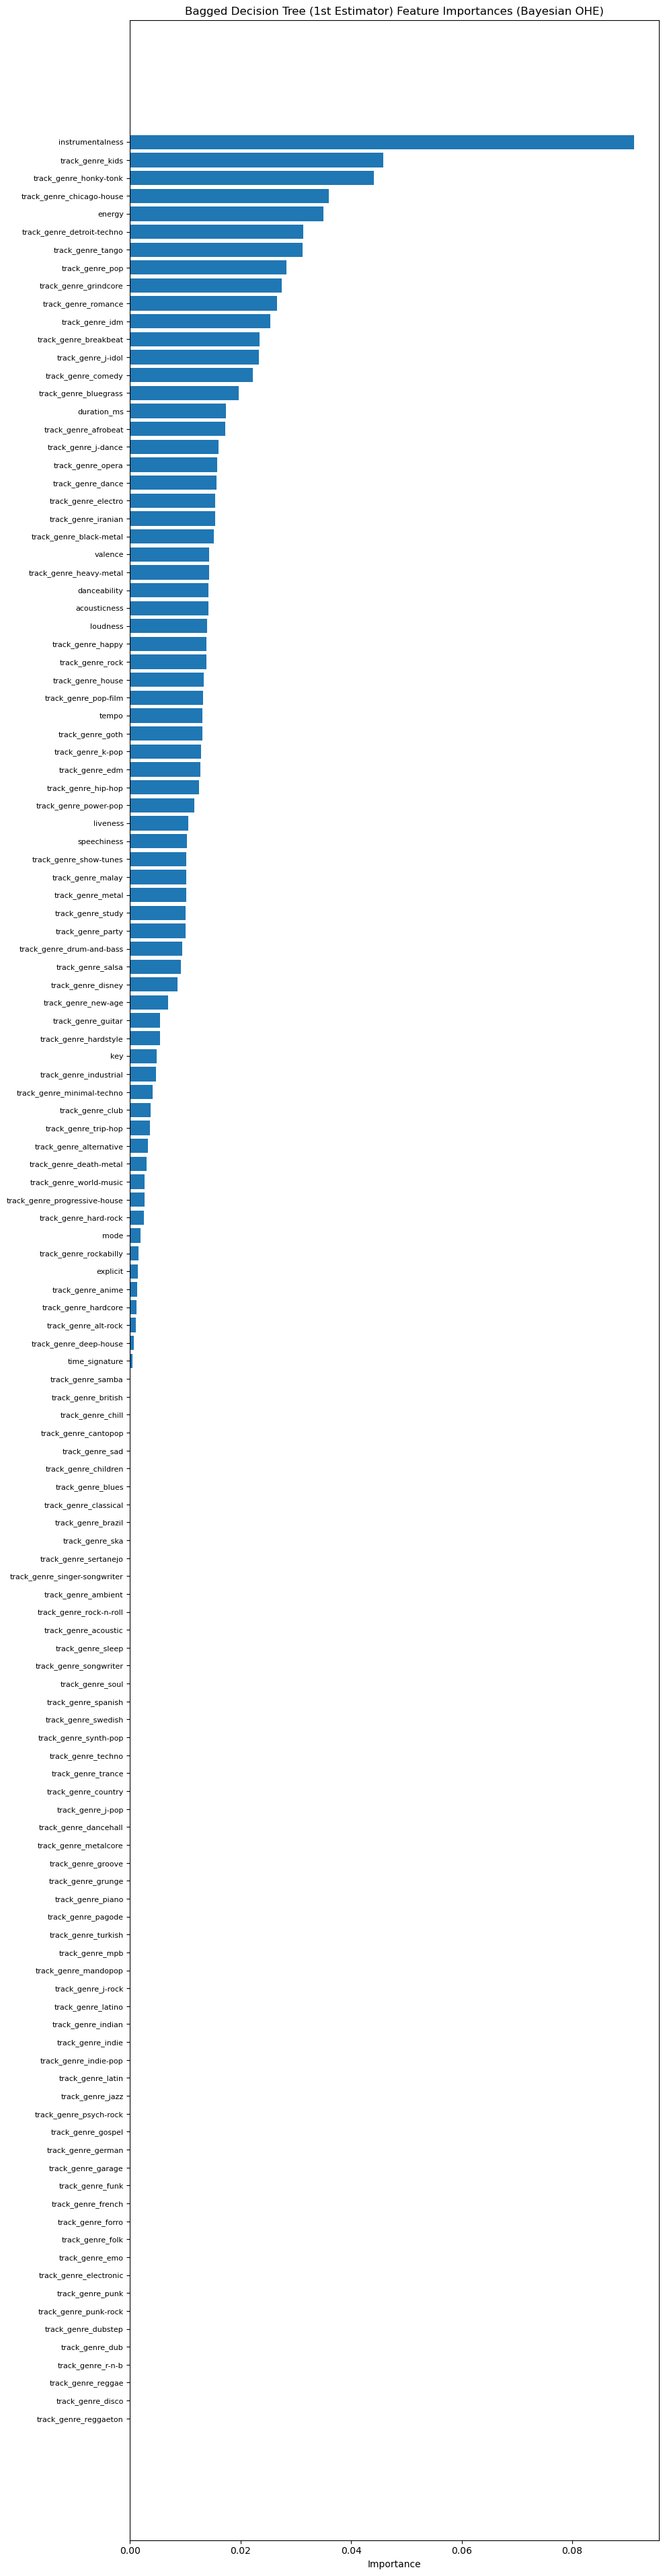

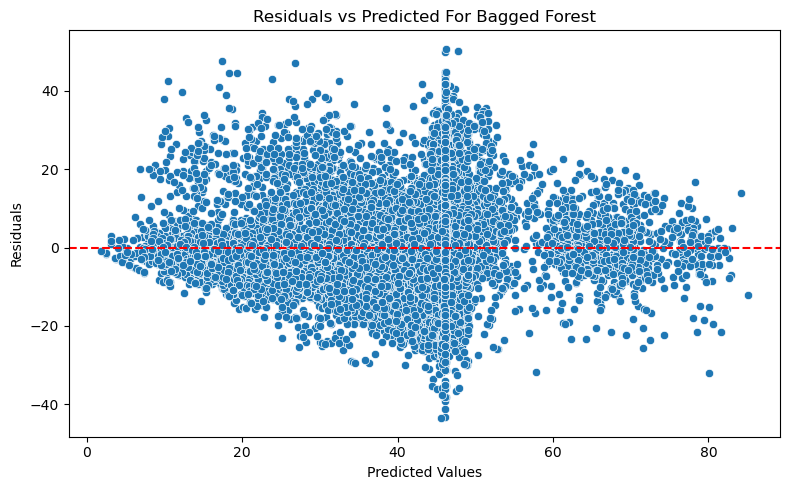

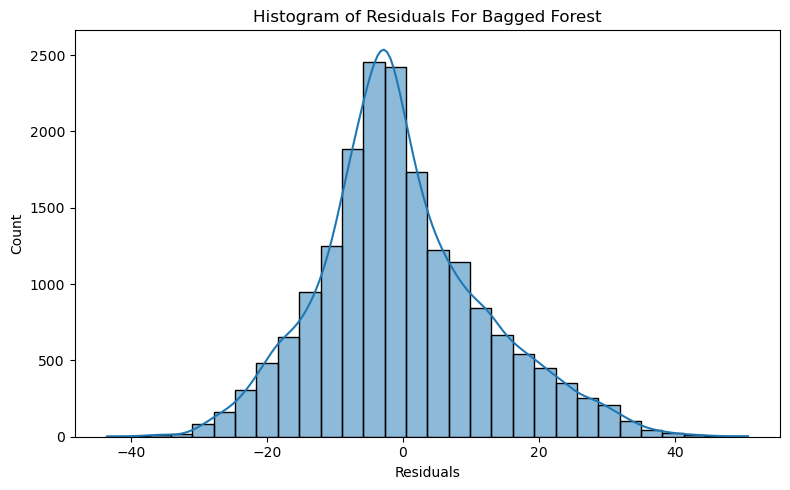

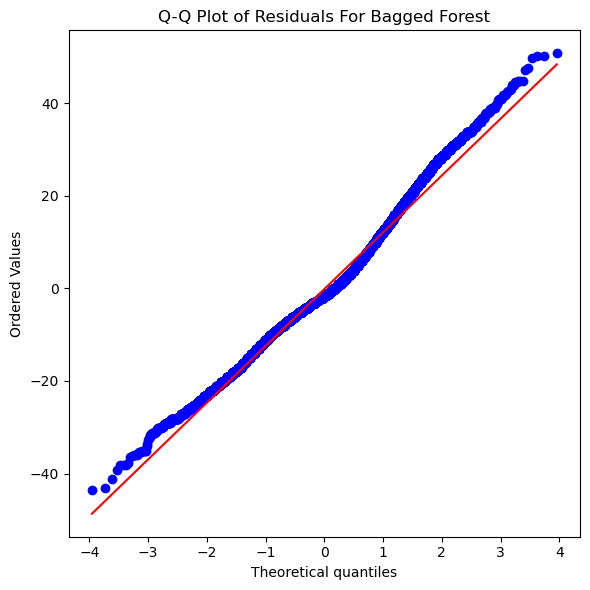

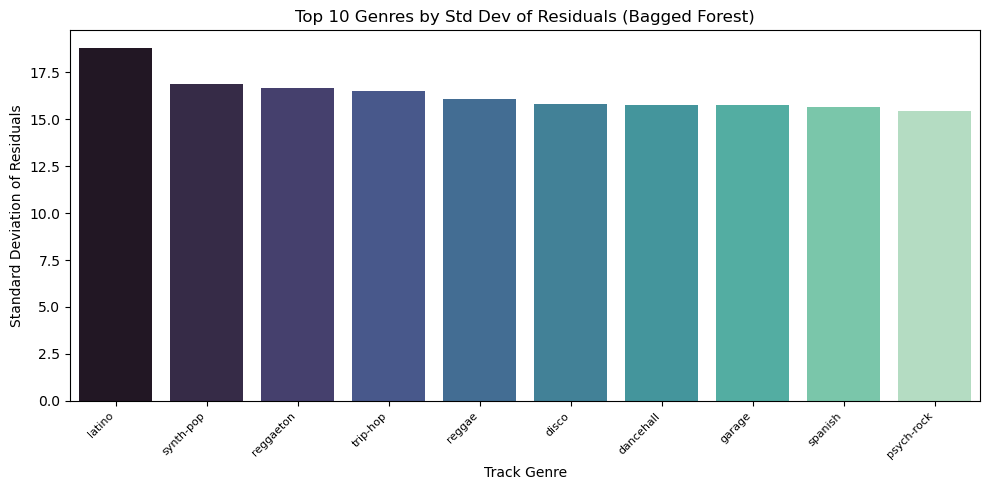

In [38]:
# Bagged Forest using Best Parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

# Load and prepare data
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Best model with parameters
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', BaggingRegressor(
        estimator=DecisionTreeRegressor(
            max_depth=30,
            min_samples_leaf=4,
            random_state=42
        ),
        n_estimators=76,
        random_state=42,
        n_jobs=-1
    ))
])


pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluation
results = {
    "Train R²": r2_score(y_train, y_train_pred),
    "Test R²": r2_score(y_test, y_test_pred),
    "Test MSE": mean_squared_error(y_test, y_test_pred)
}

# Feature importances from 1st tree
first_tree = pipeline.named_steps['model'].estimators_[0]
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = first_tree.feature_importances_
indices = np.argsort(importances)

print("Bagged Forest Results:")
for key, value in results.items():
    print(f"{key}: {value}")

# Feature importance plot (uncrammed)
plt.figure(figsize=(10, len(indices) * 0.3))
plt.title("Bagged Decision Tree (1st Estimator) Feature Importances (Bayesian OHE)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=8)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

# Residuals vs Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted For Bagged Forest")
plt.tight_layout()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals For Bagged Forest")
plt.tight_layout()
plt.show()

# Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For Bagged Forest")
plt.tight_layout()
plt.show()

# --- Top 10 Residual Std Dev by Genre (Ranked) ---

# Restore track_genre to X_test for grouping
X_test_original = X.loc[X_test.index].copy()
X_test_original['residuals'] = residuals
X_test_original['predicted'] = y_test_pred
X_test_original['actual'] = y_test.values

# Compute std deviation of residuals by genre
genre_std = X_test_original.groupby('track_genre')['residuals'].std().sort_values(ascending=False)

# Take top 10 genres only
top10_genre_std = genre_std.head(10)

# Bar Plot of Std Dev of Residuals by Genre
plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="mako")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (Bagged Forest)")
plt.ylabel("Standard Deviation of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**Finding The Best Parameters For LightGBM**

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

C:\Users\xayas\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\xayas\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Best Parameters: OrderedDict([('model__colsample_bytree', 0.5), ('model__learning_rate', 0.03), ('model__max_depth', 60), ('model__min_child_samples', 15), ('model__n_estimators', 1600), ('model__num_leaves', 360), ('model__reg_alpha', 1.0), ('model__reg_lambda', 0.5), ('model__subsample', 0.9)])
Train R^2: 0.9537944968705734
Test R^2: 0.7036681342102407
Test MSE: 94.53699398200622


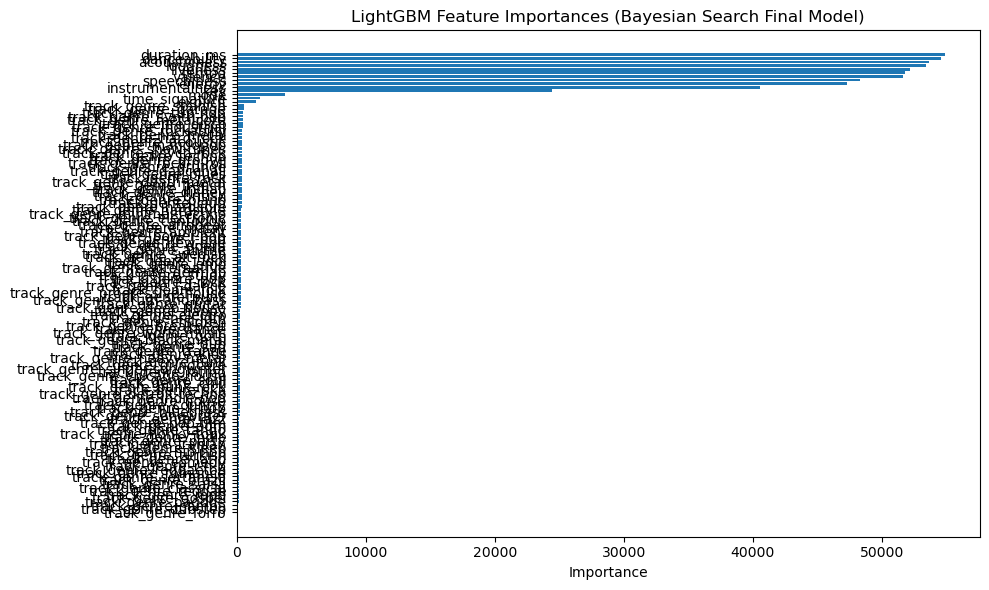

In [ ]:
# LightGBM using Bayesian Optimization to Find All Of The Best Parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer

df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LGBMRegressor(objective='regression', random_state=42, n_jobs=-1))
])

search_space = {
    'model__num_leaves': Integer(340, 360),
    'model__max_depth': Integer(40, 60),
    'model__learning_rate': Real(0.03, 0.10, prior='log-uniform'),
    'model__n_estimators': Integer(1400, 1600),
    'model__min_child_samples': Integer(15, 20),
    'model__subsample': Real(0.9, 1.0),
    'model__colsample_bytree': Real(0.2, 0.5),
    'model__reg_alpha': Real(1.0, 10.0, prior='log-uniform'),
    'model__reg_lambda': Real(0.5, 5.0, prior='log-uniform')
}

# Bayesian Optimization
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    n_iter=30,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

opt.fit(X_train, y_train)

best_pipeline = opt.best_estimator_
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

print("Best Parameters:", opt.best_params_)
print("Train R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

lgbm_model = best_pipeline.named_steps['model']
ohe = best_pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)
importances = lgbm_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("LightGBM Feature Importances (Bayesian Search Final Model)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Winning Model: LightGBM**

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2798
[LightGBM] [Info] Number of data points in the train set: 73187, number of used features: 128
[LightGBM] [Info] Start training from score 40.433615


C:\Users\xayas\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\xayas\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Train R^2: 0.9787177111964703
Test R^2: 0.7020088581668258
Train MSE: 6.819250529766482
Test MSE: 95.06634295671988


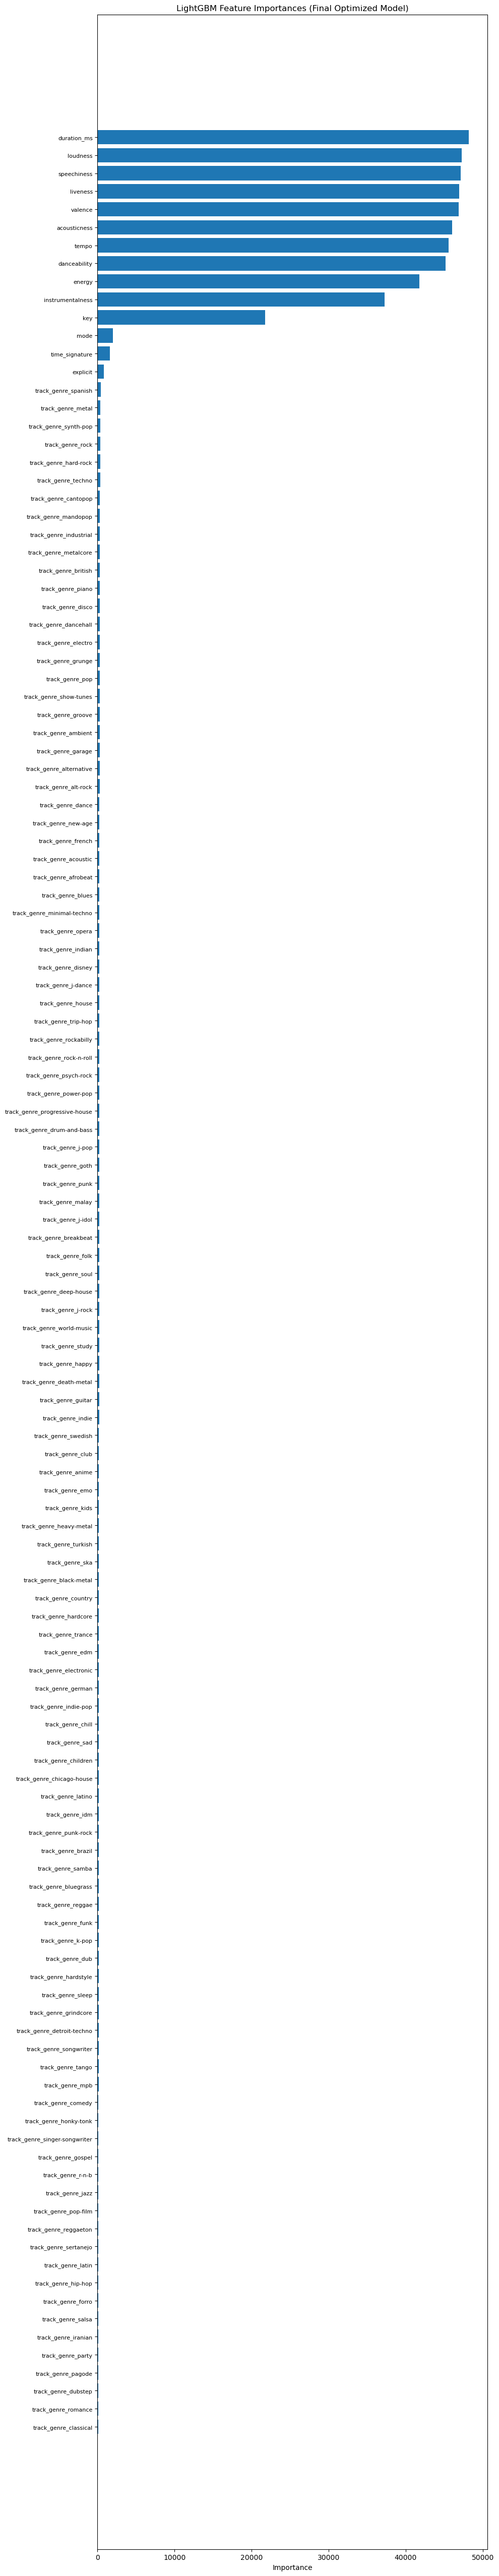

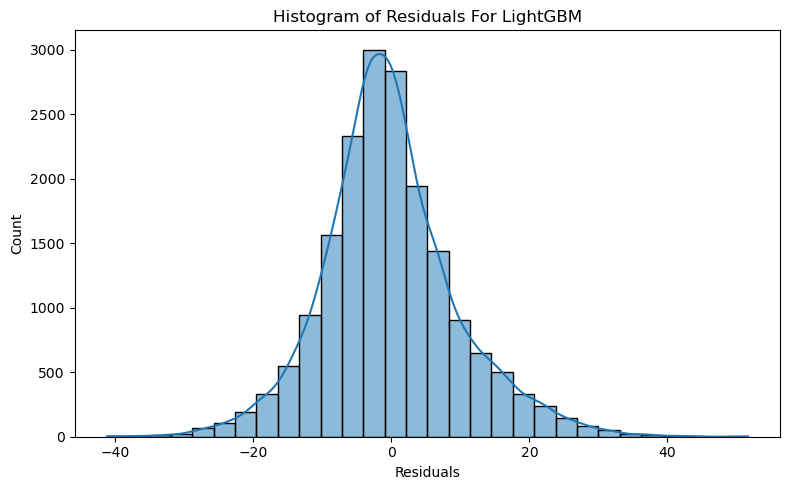

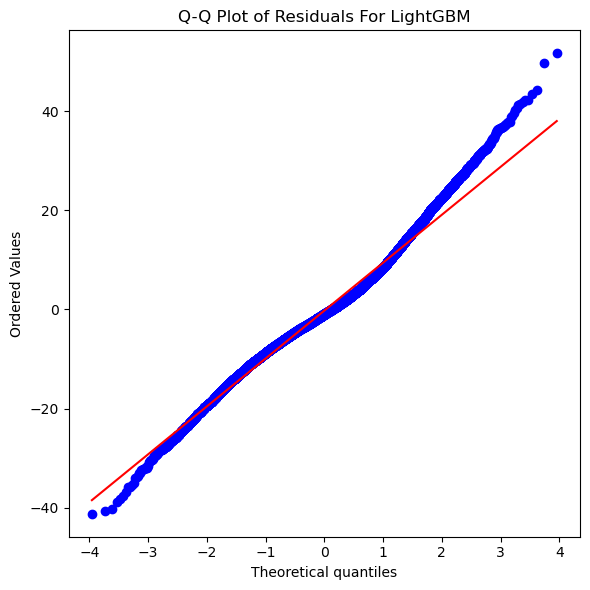

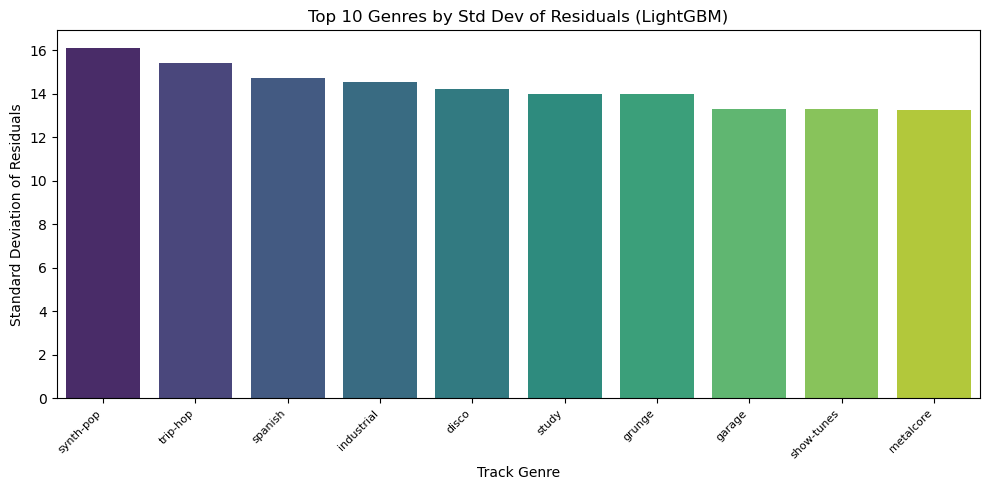

In [39]:
# LightGBM 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats

# Load and clean data
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Best parameters from Bayesian Optimization
model = LGBMRegressor(
    objective='regression',
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.42332053149109516,
    learning_rate=0.06674836528973682,
    max_depth=58,
    min_child_samples=17,
    n_estimators=1401,
    num_leaves=359,
    reg_alpha=3.7700247776742897,
    reg_lambda=3.779981995158376,
    subsample=0.9030923980367299
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

# Train
pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Scores
print("Train R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

# Feature Importances
lgbm_model = pipeline.named_steps['model']
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)
importances = lgbm_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, len(indices) * 0.4))
plt.title("LightGBM Feature Importances (Final Optimized Model)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=8)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Residuals Analysis
residuals = y_test - y_test_pred

# Residuals vs Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted For LightGBM")
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals For LightGBM")
plt.tight_layout()
plt.show()

# Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For LightGBM")
plt.tight_layout()
plt.show()

# --- Top 10 Residuals by Genre for LightGBM ---
# Get test set genre labels from original (non-transformed) X_test
X_test_original = X_test.copy()
X_test_original['residuals'] = residuals
X_test_original['predicted'] = y_test_pred
X_test_original['actual'] = y_test.values

# Add track_genre back to X_test (requires index alignment)
X_test_original['track_genre'] = X.loc[X_test.index]['track_genre'].values

# Compute std deviation of residuals per genre and take top 10
genre_std = X_test_original.groupby('track_genre')['residuals'].std().sort_values(ascending=False)
top10_genre_std = genre_std.head(10)

# Create bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="viridis")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (LightGBM)")
plt.ylabel("Standard Deviation of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**Artificial Neural Network**